In [5]:
!unzip images.zip

Archive:  images.zip
  inflating: images/0.jpg            
  inflating: images/1.jpg            
  inflating: images/10.jpg           
  inflating: images/100.jpg          
  inflating: images/1000.jpg         
  inflating: images/1001.jpg         
  inflating: images/1002.jpg         
  inflating: images/1003.jpg         
  inflating: images/1004.jpg         
  inflating: images/1005.jpg         
  inflating: images/1006.jpg         
  inflating: images/1007.jpg         
  inflating: images/1008.jpg         
  inflating: images/1009.jpg         
  inflating: images/101.jpg          
  inflating: images/1010.jpg         
  inflating: images/1011.jpg         
  inflating: images/1012.jpg         
  inflating: images/1013.jpg         
  inflating: images/1014.jpg         
  inflating: images/1015.jpg         
  inflating: images/1016.jpg         
  inflating: images/1017.jpg         
  inflating: images/1018.jpg         
  inflating: images/1019.jpg         
  inflating: images/102.jpg  

In [6]:
import pandas as pd
import numpy as np
from tqdm import tqdm
  
# for reading and displaying images
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

# torchvision for pre-trained models
from torchvision import models

In [7]:
# loading dataset
train = pd.read_csv('emergency_train.csv')
train.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [8]:
# loading training images
train_img = []
for img_name in tqdm(train['image_names']):
    # defining the image path
    image_path = 'images/' + img_name
    # reading the image
    img = imread(image_path)
    # normalizing the pixel values
    img = img/255
    # resizing the image to (224,224,3)
    img = resize(img, output_shape=(224,224,3), mode='constant', anti_aliasing=True)
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)

# converting the list to numpy array
train_x = np.array(train_img)
train_x.shape

100%|██████████| 1646/1646 [00:16<00:00, 99.74it/s] 


(1646, 224, 224, 3)

It is an Emergency vehicle


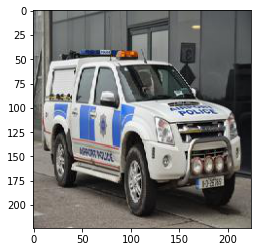

In [9]:
# Exploring the data
index = 10
plt.imshow(train_x[index])
if (train['emergency_or_not'][index] == 1):
    print('It is an Emergency vehicle')
else:
    print('It is a Non-Emergency vehicle')

In [10]:

# defining the target
train_y = train['emergency_or_not'].values

In [11]:
# create validation set
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1, random_state = 13, stratify=train_y)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((1481, 224, 224, 3), (1481,)), ((165, 224, 224, 3), (165,)))

In [12]:
# converting training images into torch format
train_x = train_x.reshape(1481, 3, 224, 224)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(int)
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([1481, 3, 224, 224]), torch.Size([1481]))

In [13]:
# converting validation images into torch format
val_x = val_x.reshape(165, 3, 224, 224)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(int)
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([165, 3, 224, 224]), torch.Size([165]))

In [14]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(8),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(8 * 56 * 56, 2)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [15]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.0001)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=25088, out_features=2, bias=True)
  )
)


In [16]:
# batch size of the model
batch_size = 128

# number of epochs to train the model
n_epochs = 15

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
        
    permutation = torch.randperm(train_x.size()[0])

    training_loss = []
    for i in tqdm(range(0,train_x.size()[0], batch_size)):

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = train_x[indices], train_y[indices]
        
        if torch.cuda.is_available():
            batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
        
        optimizer.zero_grad()
        # in case you wanted a semi-full example
        outputs = model(batch_x)
        loss = criterion(outputs,batch_y)

        training_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    training_loss = np.average(training_loss)
    print('epoch: \t', epoch, '\t training loss: \t', training_loss)

100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


epoch: 	 1 	 training loss: 	 0.8507538090149561


100%|██████████| 12/12 [00:00<00:00, 18.07it/s]


epoch: 	 2 	 training loss: 	 0.6832445114850998


100%|██████████| 12/12 [00:00<00:00, 18.24it/s]


epoch: 	 3 	 training loss: 	 0.6256658484538397


100%|██████████| 12/12 [00:00<00:00, 18.25it/s]


epoch: 	 4 	 training loss: 	 0.6056090195973715


100%|██████████| 12/12 [00:00<00:00, 18.19it/s]


epoch: 	 5 	 training loss: 	 0.583246777455012


100%|██████████| 12/12 [00:00<00:00, 18.34it/s]


epoch: 	 6 	 training loss: 	 0.5445200031002363


100%|██████████| 12/12 [00:00<00:00, 18.25it/s]


epoch: 	 7 	 training loss: 	 0.543376624584198


100%|██████████| 12/12 [00:00<00:00, 18.22it/s]


epoch: 	 8 	 training loss: 	 0.5064693416158358


100%|██████████| 12/12 [00:00<00:00, 18.05it/s]


epoch: 	 9 	 training loss: 	 0.492044135928154


100%|██████████| 12/12 [00:00<00:00, 18.06it/s]


epoch: 	 10 	 training loss: 	 0.4617263153195381


100%|██████████| 12/12 [00:00<00:00, 18.00it/s]


epoch: 	 11 	 training loss: 	 0.44377538561820984


100%|██████████| 12/12 [00:00<00:00, 18.09it/s]


epoch: 	 12 	 training loss: 	 0.44902848700682324


100%|██████████| 12/12 [00:00<00:00, 17.95it/s]


epoch: 	 13 	 training loss: 	 0.4247928311427434


100%|██████████| 12/12 [00:00<00:00, 17.79it/s]


epoch: 	 14 	 training loss: 	 0.41231105228265125


100%|██████████| 12/12 [00:00<00:00, 18.04it/s]

epoch: 	 15 	 training loss: 	 0.39413688083489734


In [17]:
# prediction for training set
prediction = []
target = []
permutation = torch.randperm(train_x.size()[0])
for i in tqdm(range(0,train_x.size()[0], batch_size)):
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = train_x[indices], train_y[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model(batch_x.cuda())

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    prediction.append(predictions)
    target.append(batch_y)
    
# training accuracy
accuracy = []
for i in range(len(prediction)):
    accuracy.append(accuracy_score(target[i].cpu(),prediction[i]))
    
print('training accuracy: \t', np.average(accuracy))

100%|██████████| 12/12 [00:00<00:00, 21.98it/s]

training accuracy: 	 0.8816441923515982


In [18]:
# prediction for validation set
prediction_val = []
target_val = []
permutation = torch.randperm(val_x.size()[0])
for i in tqdm(range(0,val_x.size()[0], batch_size)):
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = val_x[indices], val_y[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model(batch_x.cuda())

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    prediction_val.append(predictions)
    target_val.append(batch_y)
    
# validation accuracy
accuracy_val = []
for i in range(len(prediction_val)):
    accuracy_val.append(accuracy_score(target_val[i].cpu(),prediction_val[i]))
    
print('validation accuracy: \t', np.average(accuracy_val))

100%|██████████| 2/2 [00:00<00:00, 32.83it/s]

validation accuracy: 	 0.6641680743243243


*VGG
*

In [19]:
# loading the pretrained model
model = models.vgg16_bn(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [20]:
# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

In [21]:
# checking if GPU is available
if torch.cuda.is_available():
  model = model.cuda()

In [22]:
# Add on classifier
model.classifier[6] = Sequential(
                      Linear(4096, 2))
for param in model.classifier[6].parameters():
    param.requires_grad = True

In [23]:
# batch_size
batch_size = 128

# extracting features for train data
data_x = []
label_x = []

inputs,labels = train_x, train_y

for i in tqdm(range(int(train_x.shape[0]/batch_size)+1)):
    input_data = inputs[i*batch_size:(i+1)*batch_size]
    label_data = labels[i*batch_size:(i+1)*batch_size]
    input_data , label_data = Variable(input_data.cuda()),Variable(label_data.cuda())
    x = model.features(input_data)
    data_x.extend(x.data.cpu().numpy())
    label_x.extend(label_data.data.cpu().numpy())

100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


In [24]:
# extracting features for validation data
data_y = []
label_y = []

inputs,labels = val_x, val_y

for i in tqdm(range(int(val_x.shape[0]/batch_size)+1)):
    input_data = inputs[i*batch_size:(i+1)*batch_size]
    label_data = labels[i*batch_size:(i+1)*batch_size]
    input_data , label_data = Variable(input_data.cuda()),Variable(label_data.cuda())
    x = model.features(input_data)
    data_y.extend(x.data.cpu().numpy())
    label_y.extend(label_data.data.cpu().numpy())

100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


In [25]:
# converting the features into torch format
x_train  = torch.from_numpy(np.array(data_x))
x_train = x_train.view(x_train.size(0), -1)
y_train  = torch.from_numpy(np.array(label_x))
x_val  = torch.from_numpy(np.array(data_y))
x_val = x_val.view(x_val.size(0), -1)
y_val  = torch.from_numpy(np.array(label_y))

In [26]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.0005)

In [27]:
# batch size
batch_size = 128
#model=model.to("cuda")
# number of epochs to train the model
n_epochs = 30

for epoch in tqdm(range(1, n_epochs+1)):

    # keep track of training and validation loss
    train_loss = 0.0
        
    permutation = torch.randperm(x_train.size()[0])

    training_loss = []
    for i in range(0,x_train.size()[0], batch_size):

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x_train[indices], y_train[indices]
        if torch.cuda.is_available():
            batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
        
        
        
        
        optimizer.zero_grad()
        # in case you wanted a semi-full example
        device = torch.device("cuda")
        model.cuda()
        outputs = model.classifier(batch_x.cuda())
        loss = criterion(outputs,batch_y)

        training_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    training_loss = np.average(training_loss)
    print('epoch: \t', epoch, '\t training loss: \t', training_loss)

  7%|▋         | 2/30 [00:00<00:04,  6.20it/s]

epoch: 	 1 	 training loss: 	 0.5973723729451498
epoch: 	 2 	 training loss: 	 0.5053841769695282


 13%|█▎        | 4/30 [00:00<00:04,  6.20it/s]

epoch: 	 3 	 training loss: 	 0.4688763717810313
epoch: 	 4 	 training loss: 	 0.4474605868260066


 20%|██        | 6/30 [00:00<00:03,  6.20it/s]

epoch: 	 5 	 training loss: 	 0.43452779948711395
epoch: 	 6 	 training loss: 	 0.42870162179072696


 27%|██▋       | 8/30 [00:01<00:03,  6.22it/s]

epoch: 	 7 	 training loss: 	 0.4175368870298068
epoch: 	 8 	 training loss: 	 0.40945447981357574


 33%|███▎      | 10/30 [00:01<00:03,  6.26it/s]

epoch: 	 9 	 training loss: 	 0.4063165709376335
epoch: 	 10 	 training loss: 	 0.39695681383212406


 40%|████      | 12/30 [00:01<00:02,  6.27it/s]

epoch: 	 11 	 training loss: 	 0.40362581113974255
epoch: 	 12 	 training loss: 	 0.3856736421585083


 47%|████▋     | 14/30 [00:02<00:02,  6.25it/s]

epoch: 	 13 	 training loss: 	 0.38204654802878696
epoch: 	 14 	 training loss: 	 0.38777056833108264


 53%|█████▎    | 16/30 [00:02<00:02,  6.15it/s]

epoch: 	 15 	 training loss: 	 0.37194033960501355
epoch: 	 16 	 training loss: 	 0.37920672198136646


 60%|██████    | 18/30 [00:02<00:01,  6.15it/s]

epoch: 	 17 	 training loss: 	 0.36508981386820477
epoch: 	 18 	 training loss: 	 0.36635201921065647


 67%|██████▋   | 20/30 [00:03<00:01,  6.18it/s]

epoch: 	 19 	 training loss: 	 0.35791105031967163
epoch: 	 20 	 training loss: 	 0.37781838079293567


 73%|███████▎  | 22/30 [00:03<00:01,  6.21it/s]

epoch: 	 21 	 training loss: 	 0.3727813934286435
epoch: 	 22 	 training loss: 	 0.3543715054790179


 80%|████████  | 24/30 [00:03<00:00,  6.21it/s]

epoch: 	 23 	 training loss: 	 0.3700600564479828
epoch: 	 24 	 training loss: 	 0.3665624012549718


 87%|████████▋ | 26/30 [00:04<00:00,  6.21it/s]

epoch: 	 25 	 training loss: 	 0.3560411085685094
epoch: 	 26 	 training loss: 	 0.35362013677755993


 93%|█████████▎| 28/30 [00:04<00:00,  6.32it/s]

epoch: 	 27 	 training loss: 	 0.35416282961765927
epoch: 	 28 	 training loss: 	 0.36161772906780243


100%|██████████| 30/30 [00:04<00:00,  6.21it/s]

epoch: 	 29 	 training loss: 	 0.3335576703151067
epoch: 	 30 	 training loss: 	 0.34084229667981464


In [28]:
# prediction for training set
prediction = []
target = []
permutation = torch.randperm(x_train.size()[0])
for i in tqdm(range(0,x_train.size()[0], batch_size)):
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = x_train[indices], y_train[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model.classifier(batch_x.cuda())

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    prediction.append(predictions)
    target.append(batch_y)
    
# training accuracy
accuracy = []
for i in range(len(prediction)):
    accuracy.append(accuracy_score(target[i].cpu(),prediction[i]))
    
print('training accuracy: \t', np.average(accuracy))

100%|██████████| 12/12 [00:00<00:00, 82.65it/s]

training accuracy: 	 0.849734232305936


In [29]:
# prediction for validation set
prediction_val = []
target_val = []
permutation = torch.randperm(x_val.size()[0])
for i in tqdm(range(0,x_val.size()[0], batch_size)):
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = x_val[indices], y_val[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model.classifier(batch_x.cuda())

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    prediction_val.append(predictions)
    target_val.append(batch_y)
    
# validation accuracy
accuracy_val = []
for i in range(len(prediction_val)):
    accuracy_val.append(accuracy_score(target_val[i].cpu(),prediction_val[i]))
    
print('validation accuracy: \t', np.average(accuracy_val))

100%|██████████| 2/2 [00:00<00:00, 100.00it/s]

validation accuracy: 	 0.8251689189189189
